In [2]:
from scapy.all import *
import math
import matplotlib.pyplot as plt
import numpy as np

# fuente para esto https://en.wikipedia.org/wiki/EtherType y https://www.calculator.net/hex-calculator.html
proto_dict = { 2048 : "IPv4", 2054 : "ARP", 34525 : "IPv6", 34958 : "EAP over LAN", 35018 : "TIPC", 35020 : "LLDP" , 35130 : "IEEE 1905.1"}

<h1>FUNCIONES</h1>

In [3]:
def entropia_fuente(S):
    N = sum(S.values())
    simbolos = sorted(S.items(), key=lambda x: -x[1])
    return -sum([ (k/N)*math.log2(k/N) for d,k in simbolos ])

def mostrar_entropia(S):
    print("Entropia de la fuente: %.5f\n" % entropia_fuente(S))

def informacion_de_evento(S, s_i):
    k = S[s_i]
    N = sum(S.values())
    return -math.log2(k/N)

def informacion_de_eventos(S):
    N = sum(S.values())
    return { s_i : -math.log2(k/N) for s_i,k in S.items() }

def mostrar_informacion_de_eventos(S):
    for s_i in S:
        print("Informacion de evento %s: %.5f" % (s_i, informacion_de_evento(S, s_i)))
    print("\n")

def mostrar_fuente(S):
    N = sum(S.values())
    simbolos = sorted(S.items(), key=lambda x: -x[1])
    print("\n".join([ " %s : %.5f" % (d,k/N) for d,k in simbolos ]))
    print()

def callback(pkt, S):
    if pkt.haslayer(Ether):
        dire = "BROADCAST" if pkt[Ether].dst=="ff:ff:ff:ff:ff:ff" else "UNICAST"
        proto = pkt[Ether].type # El campo type del frame tiene el protocolo
        s_i = (dire, proto) # Aca se define el simbolo de la fuente
        if s_i not in S:
            S[s_i] = 0.0
        S[s_i] += 1.0

def porcentaje_de_tipos_de_destinos(S, tipo_de_destino):
    N = sum(S.values())
    return sum([k for d,k in S.items() if d[0]==tipo_de_destino])/N

def mostrar_porcentaje_de_tipos_de_destinos(S):
    print("Porcentaje de paquetes UNICAST: %.5f" % porcentaje_de_tipos_de_destinos(S, "UNICAST"))
    print("Porcentaje de paquetes BROADCAST: %.5f\n" % porcentaje_de_tipos_de_destinos(S, "BROADCAST"))

def protocolos_fuente(S):
    return set([s_i[1] for s_i in S])

def porcentaje_de_protocolo(S, protocolo):
    N = sum(S.values())
    return sum([k for d,k in S.items() if d[1]==protocolo])/N

def mostrar_porcentaje_de_protocolos(S):
    for protocolo in protocolos_fuente(S):
        if protocolo in proto_dict:
            nombre_protocolo = proto_dict[protocolo]
        else:
            nombre_protocolo = protocolo
        print("Porcentaje de paquetes %s: %.5f" % (nombre_protocolo, porcentaje_de_protocolo(S, protocolo)))
    print()

def mostrar_resultados(S, pkt_dump):
    print("Cantidad de paquetes: %d" % len(pkt_dump))
    print("Cantidad de paquetes con capa Ethernet: %d\n" % sum(S.values()))
    print("Fuente:")
    mostrar_fuente(S)
    print("Entropia:")
    mostrar_entropia(S)
    print("Tipos de Destinos:")
    mostrar_porcentaje_de_tipos_de_destinos(S)
    print("Protocolos:")
    mostrar_porcentaje_de_protocolos(S)
    print("Informacion de eventos:")
    mostrar_informacion_de_eventos(S)
    arp_dict = filtrar_ARP(pkt_dump)
    fuentes_dict_IP_req, fuentes_dict_IP_rep = arp_fuentes(arp_dict)
    dest_dict_IP_req, dest_dict_IP_rep = arp_destinos(arp_dict)
    print("ARP fuentes REQUEST:")
    print(fuentes_dict_IP_req)
    print("ARP fuentes REPLY:")
    print(fuentes_dict_IP_rep)
    print("ARP destinos REQUEST:")
    print(dest_dict_IP_req)
    print("ARP destinos REPLY:")
    print(dest_dict_IP_rep)

def filtrar_ARP(pkt_dump):
    arp = [pkt for pkt in pkt_dump if pkt.haslayer(Ether) and pkt[Ether].type==2054]
    arp_dict = {}
    for pkt in arp:
        s_i = (pkt[ARP].op, pkt[ARP].psrc, pkt[ARP].pdst)
        if s_i not in arp_dict:
            arp_dict[s_i] = 0
        arp_dict[s_i] += 1
    return arp_dict

def filtrar_ARP_opcional_req_src(pkt_dump):
    arp = [pkt for pkt in pkt_dump if pkt.haslayer(Ether) and pkt[Ether].type==2054]
    arp_dict = {}
    for pkt in arp:
        if pkt[ARP].op == 1:
            s_i = (pkt[ARP].psrc)
            if s_i not in arp_dict:
                arp_dict[s_i] = 0
            arp_dict[s_i] += 1
    return arp_dict

def filtrar_ARP_opcional_req_dst(pkt_dump):
    arp = [pkt for pkt in pkt_dump if pkt.haslayer(Ether) and pkt[Ether].type==2054]
    arp_dict = {}
    for pkt in arp:
        if pkt[ARP].op == 1:
            s_i = (pkt[ARP].pdst)
            if s_i not in arp_dict:
                arp_dict[s_i] = 0
            arp_dict[s_i] += 1
    return arp_dict

def arp_fuentes(arp_dict):
    simbolos_arp = sorted(arp_dict.items(), key=lambda x: -x[1])
    fuentes_dict_IP_rep = {}
    fuentes_dict_IP_req = {}
    for simbolo_arp, count in simbolos_arp:
        if simbolo_arp[0] == 1:
            if simbolo_arp[1] not in fuentes_dict_IP_req:
                fuentes_dict_IP_req[simbolo_arp[1]] = 0
            fuentes_dict_IP_req[simbolo_arp[1]] += count
        else:
            if simbolo_arp[1] not in fuentes_dict_IP_rep:
                fuentes_dict_IP_rep[simbolo_arp[1]] = 0
            fuentes_dict_IP_rep[simbolo_arp[1]] += count
    return fuentes_dict_IP_req, fuentes_dict_IP_rep

def arp_destinos(arp_dict):
    simbolos_arp = sorted(arp_dict.items(), key=lambda x: -x[1])
    dest_dict_IP_rep = {}
    dest_dict_IP_req = {}
    for simbolo_arp, count in simbolos_arp:
        if simbolo_arp[0] == 1:
            if simbolo_arp[2] not in dest_dict_IP_req:
                dest_dict_IP_req[simbolo_arp[2]] = 0
            dest_dict_IP_req[simbolo_arp[2]] += count
        else:
            if simbolo_arp[2] not in dest_dict_IP_rep:
                dest_dict_IP_rep[simbolo_arp[2]] = 0
            dest_dict_IP_rep[simbolo_arp[2]] += count
    return dest_dict_IP_req, dest_dict_IP_rep

def protocolos_fuente_dict(S):
    protos = protocolos_fuente(S)
    proto_dict = {}
    for p in protos:
        proto_dict[p] = 0
    for s_i in S:
        proto_dict[s_i[1]] += 1
    return proto_dict

def filtrar_bajos_porcentajes(porcentaje):
    if porcentaje > 4.5:
        return '%1.1f%%'%porcentaje

<h1>CARGAR Y PROCESAR DUMPS</h1>

In [4]:
# NO SE PROVEEN LOS DUMPS
filename1 = "DUMPS/..."
filename2 = "DUMPS/..."
filename3 = "DUMPS/..."
filename4 = "DUMPS/..."

S1 = {}
S2 = {}
S3 = {}
S4 = {}

dump_de_frames1 = rdpcap(filename1)
for pkt in dump_de_frames1:
     callback(pkt, S1)

dump_de_frames2 = rdpcap(filename2)
for pkt in dump_de_frames2:
     callback(pkt, S2)

dump_de_frames3 = rdpcap(filename3)
for pkt in dump_de_frames3:
     callback(pkt, S3)

dump_de_frames4 = rdpcap(filename4)
for pkt in dump_de_frames4:
     callback(pkt, S4)

<h1>GRAFICOS INFORME</h1>

<h2>Subplots Unicast vs. Broadcast</h2>

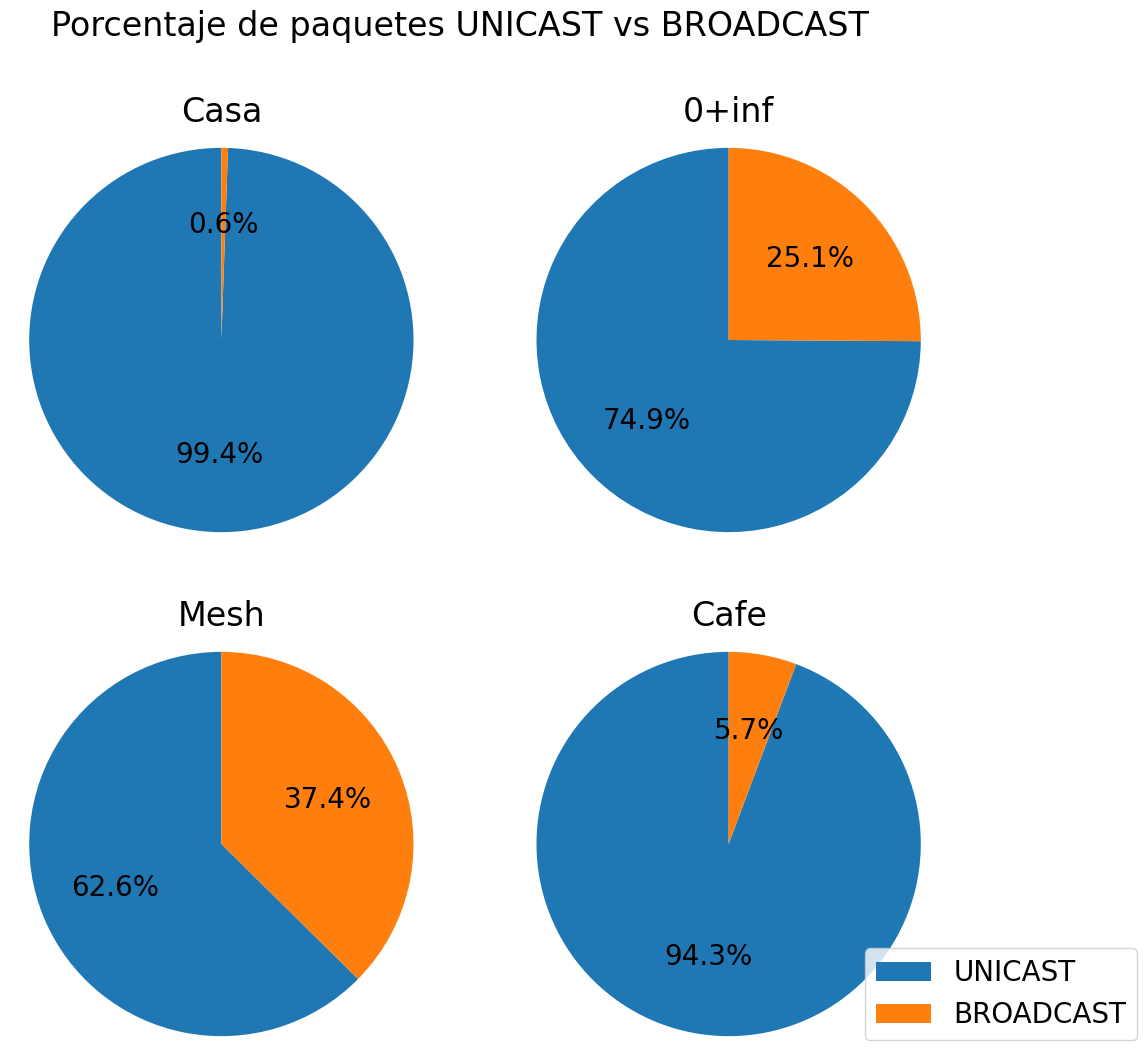

In [5]:
def graficar_subplot_torta_unicast_broadcast(S1, S2, S3, S4):
    plt.rcParams.update({'font.size': 20})
    unicast1 = porcentaje_de_tipos_de_destinos(S1, "UNICAST")
    broadcast1 = porcentaje_de_tipos_de_destinos(S1, "BROADCAST")
    unicast2 = porcentaje_de_tipos_de_destinos(S2, "UNICAST")
    broadcast2 = porcentaje_de_tipos_de_destinos(S2, "BROADCAST")
    unicast3 = porcentaje_de_tipos_de_destinos(S3, "UNICAST")
    broadcast3 = porcentaje_de_tipos_de_destinos(S3, "BROADCAST")
    unicast4 = porcentaje_de_tipos_de_destinos(S4, "UNICAST")
    broadcast4 = porcentaje_de_tipos_de_destinos(S4, "BROADCAST")
    labels = ["UNICAST", "BROADCAST"]
    sizes1 = [unicast1, broadcast1]
    sizes2 = [unicast2, broadcast2]
    sizes3 = [unicast3, broadcast3]
    sizes4 = [unicast4, broadcast4]
    fig1, ax1 = plt.subplots(2, 2)
    ax1[0][0].pie(sizes1, autopct='%1.1f%%', startangle=90)
    ax1[0][1].pie(sizes2, autopct='%1.1f%%', startangle=90)
    ax1[1][0].pie(sizes3, autopct='%1.1f%%', startangle=90)
    ax1[1][1].pie(sizes4, autopct='%1.1f%%', startangle=90)
    ax1[0][0].axis('equal')
    ax1[0][1].axis('equal')
    ax1[1][0].axis('equal')
    ax1[1][1].axis('equal')
    plt.gcf().set_size_inches(12, 12)
    ax1[1][1].legend(labels, loc="lower right", bbox_to_anchor=(1.0, 0, 0.5, 1))
    ax1[0][0].set_title('Casa')
    ax1[0][1].set_title('0+inf')
    ax1[1][0].set_title('Mesh')
    ax1[1][1].set_title('Cafe')
    plt.suptitle("Porcentaje de paquetes UNICAST vs BROADCAST")
    plt.savefig("SVG/UnicastVsBroadcast.svg", format="svg")
    plt.show()

graficar_subplot_torta_unicast_broadcast(S1, S2, S3, S4)

<h2>Subplot porcentaje de apariciones de protocolo por red</h2>

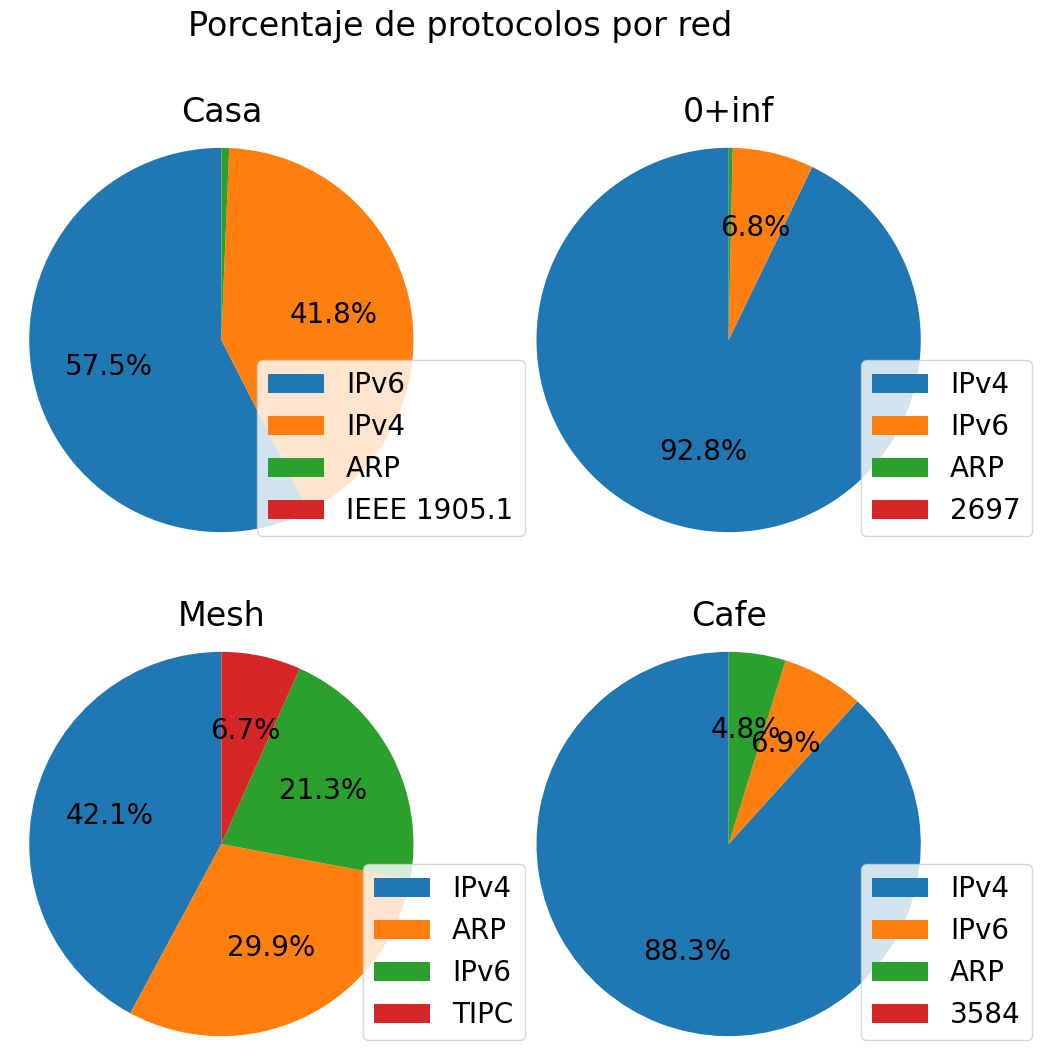

In [6]:
def graficar_subplot_torta_protocolos(S1, S2, S3, S4):
    proto1 = list(protocolos_fuente(S1))
    percentage1 = [porcentaje_de_protocolo(S1, proto) for proto in proto1]
    proto2 = list(protocolos_fuente(S2))
    percentage2 = [porcentaje_de_protocolo(S2, proto) for proto in proto2]
    proto3 = list(protocolos_fuente(S3))
    percentage3 = [porcentaje_de_protocolo(S3, proto) for proto in proto3]
    proto4 = list(protocolos_fuente(S4))
    percentage4 = [porcentaje_de_protocolo(S4, proto) for proto in proto4]
    proto_dict1 = dict(zip(proto1, percentage1))
    proto_dict2 = dict(zip(proto2, percentage2))
    proto_dict3 = dict(zip(proto3, percentage3))
    proto_dict4 = dict(zip(proto4, percentage4))
    sim1 = sorted(proto_dict1.items(), key=lambda x: -x[1])
    sim2 = sorted(proto_dict2.items(), key=lambda x: -x[1])
    sim3 = sorted(proto_dict3.items(), key=lambda x: -x[1])
    sim4 = sorted(proto_dict4.items(), key=lambda x: -x[1])
    proto1 = []
    percentage1 = []
    for d,k in sim1:
        proto1.append(d)
        percentage1.append(k)
    proto2 = []
    percentage2 = []
    for d,k in sim2:
        proto2.append(d)
        percentage2.append(k)
    proto3 = []
    percentage3 = []
    for d,k in sim3:
        proto3.append(d)
        percentage3.append(k)
    proto4 = []
    percentage4 = []
    for d,k in sim4:
        proto4.append(d)
        percentage4.append(k)
    plt.rcParams.update({'font.size': 20})
    proto1 = [proto_dict[proto] if proto in proto_dict else proto for proto in proto1]
    proto2 = [proto_dict[proto] if proto in proto_dict else proto for proto in proto2]
    proto3 = [proto_dict[proto] if proto in proto_dict else proto for proto in proto3]
    proto4 = [proto_dict[proto] if proto in proto_dict else proto for proto in proto4]
    fig1, ax1 = list(plt.subplots(2, 2))
    ax1[0][0].pie(percentage1, autopct=lambda p: filtrar_bajos_porcentajes(p), startangle=90)
    ax1[0][1].pie(percentage2, autopct=lambda p: filtrar_bajos_porcentajes(p), startangle=90)
    ax1[1][0].pie(percentage3, autopct=lambda p: filtrar_bajos_porcentajes(p), startangle=90)
    ax1[1][1].pie(percentage4, autopct=lambda p: filtrar_bajos_porcentajes(p), startangle=90)
    ax1[0][0].axis('equal')
    ax1[0][1].axis('equal')
    ax1[1][0].axis('equal')
    ax1[1][1].axis('equal')
    plt.gcf().set_size_inches(12, 12)
    ax1[0][0].legend(proto1, loc="lower right", bbox_to_anchor=(0.75, 0, 0.5, 1))
    ax1[0][1].legend(proto2, loc="lower right", bbox_to_anchor=(0.75, 0, 0.5, 1))
    ax1[1][0].legend(proto3, loc="lower right", bbox_to_anchor=(0.75, 0, 0.5, 1))
    ax1[1][1].legend(proto4, loc="lower right", bbox_to_anchor=(0.75, 0, 0.5, 1))
    ax1[0][0].set_title('Casa')
    ax1[0][1].set_title('0+inf')
    ax1[1][0].set_title('Mesh')
    ax1[1][1].set_title('Cafe')
    plt.suptitle("Porcentaje de protocolos por red")
    plt.savefig("SVG/SubplotPP.svg", format="svg")
    plt.show()

graficar_subplot_torta_protocolos(S1, S2, S3, S4)

<h2>Grafico de barras de entropia de cada red</h2>

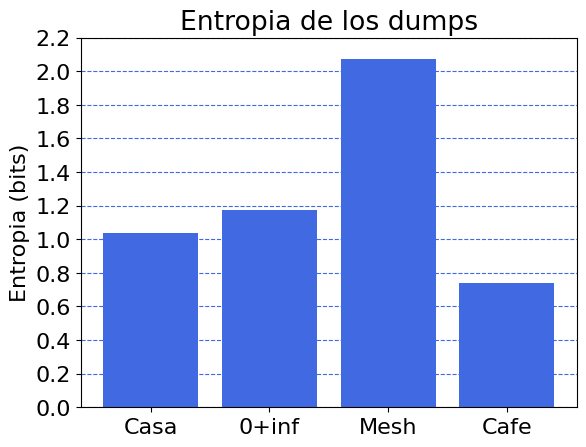

In [7]:
def graficar_barras_entropia(S1, S2, S3, S4):
    plt.rcParams.update({'font.size': 16})
    entropia1 = entropia_fuente(S1)
    entropia2 = entropia_fuente(S2)
    entropia3 = entropia_fuente(S3)
    entropia4 = entropia_fuente(S4)
    entropias = [entropia1, entropia2, entropia3, entropia4]
    fig, ax = plt.subplots()
    ax.grid(axis="y", color="royalblue", linestyle="--")
    ax.bar(["Casa", "0+inf", "Mesh", "Cafe"], entropias, color="royalblue")
    ax.set_title("Entropia de los dumps")
    ax.set_ylabel("Entropia (bits)")
    ax.set_yticks(np.arange(0, 2.4, 0.2))
    plt.savefig("SVG/Entropias.svg", format="svg")
    plt.show()

graficar_barras_entropia(S1, S2, S3, S4)

<h2>Porcentaje de aparicion de cada simbolo en red de mayor y menor entropia</h2>

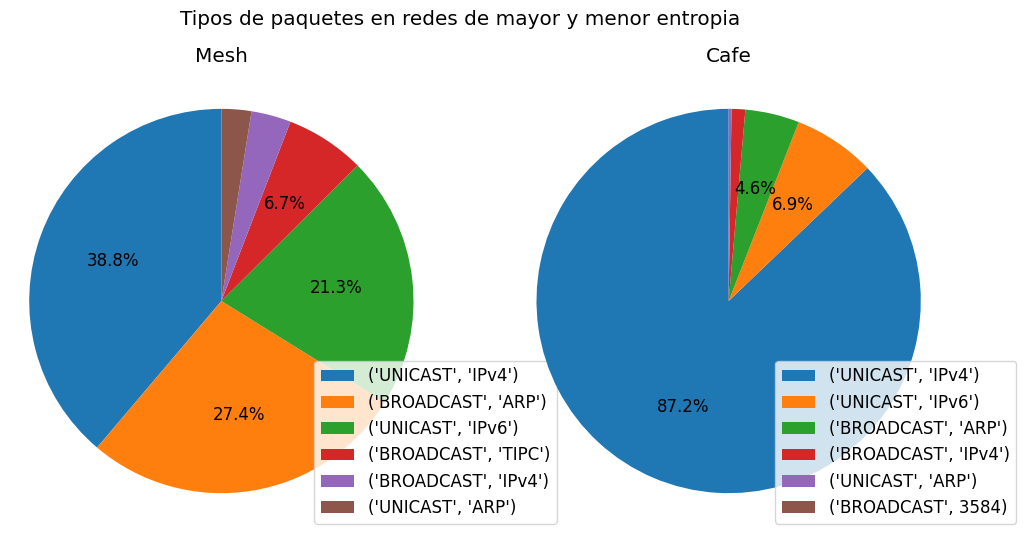

In [8]:
def graficar_subplot_torta_fuentes(S1, S2):
    plt.rcParams.update({'font.size': 12})
    N1 = sum(S1.values())
    simbolos1 = sorted(S1.items(), key=lambda x: -x[1])
    labels1 = [d for d,k in simbolos1]
    sizes1 = [k/N1 for d,k in simbolos1]
    for i in range(len(labels1)):
        if labels1[i][1] in proto_dict:
            labels1[i] = (labels1[i][0], proto_dict[labels1[i][1]])
    N2 = sum(S2.values())
    simbolos2 = sorted(S2.items(), key=lambda x: -x[1])
    labels2 = [d for d,k in simbolos2]
    sizes2 = [k/N2 for d,k in simbolos2]
    for i in range(len(labels2)):
        if labels2[i][1] in proto_dict:
            labels2[i] = (labels2[i][0], proto_dict[labels2[i][1]])
    fig1, ax1 = plt.subplots(1,2)
    ax1[0].pie(sizes1, autopct=lambda p: filtrar_bajos_porcentajes(p), startangle=90)
    ax1[1].pie(sizes2, autopct=lambda p: filtrar_bajos_porcentajes(p), startangle=90)
    ax1[0].axis('equal')
    ax1[1].axis('equal')
    plt.gcf().set_size_inches(12, 6)
    ax1[0].legend(labels1, loc="lower left", bbox_to_anchor=(0.7, 0, 0.5, 1))
    ax1[1].legend(labels2, loc="lower right", bbox_to_anchor=(0.7, 0, 0.5, 1))
    ax1[0].set_title('Mesh')
    ax1[1].set_title('Cafe')
    plt.suptitle("Tipos de paquetes en redes de mayor y menor entropia")
    plt.savefig("SVG/SubplotTortaFuentes.svg", format="svg")
    plt.show()

graficar_subplot_torta_fuentes(S3, S4)

<h2>Grafico de barras horizontales de informacion de cada evento comparado con entropia por red</h2>

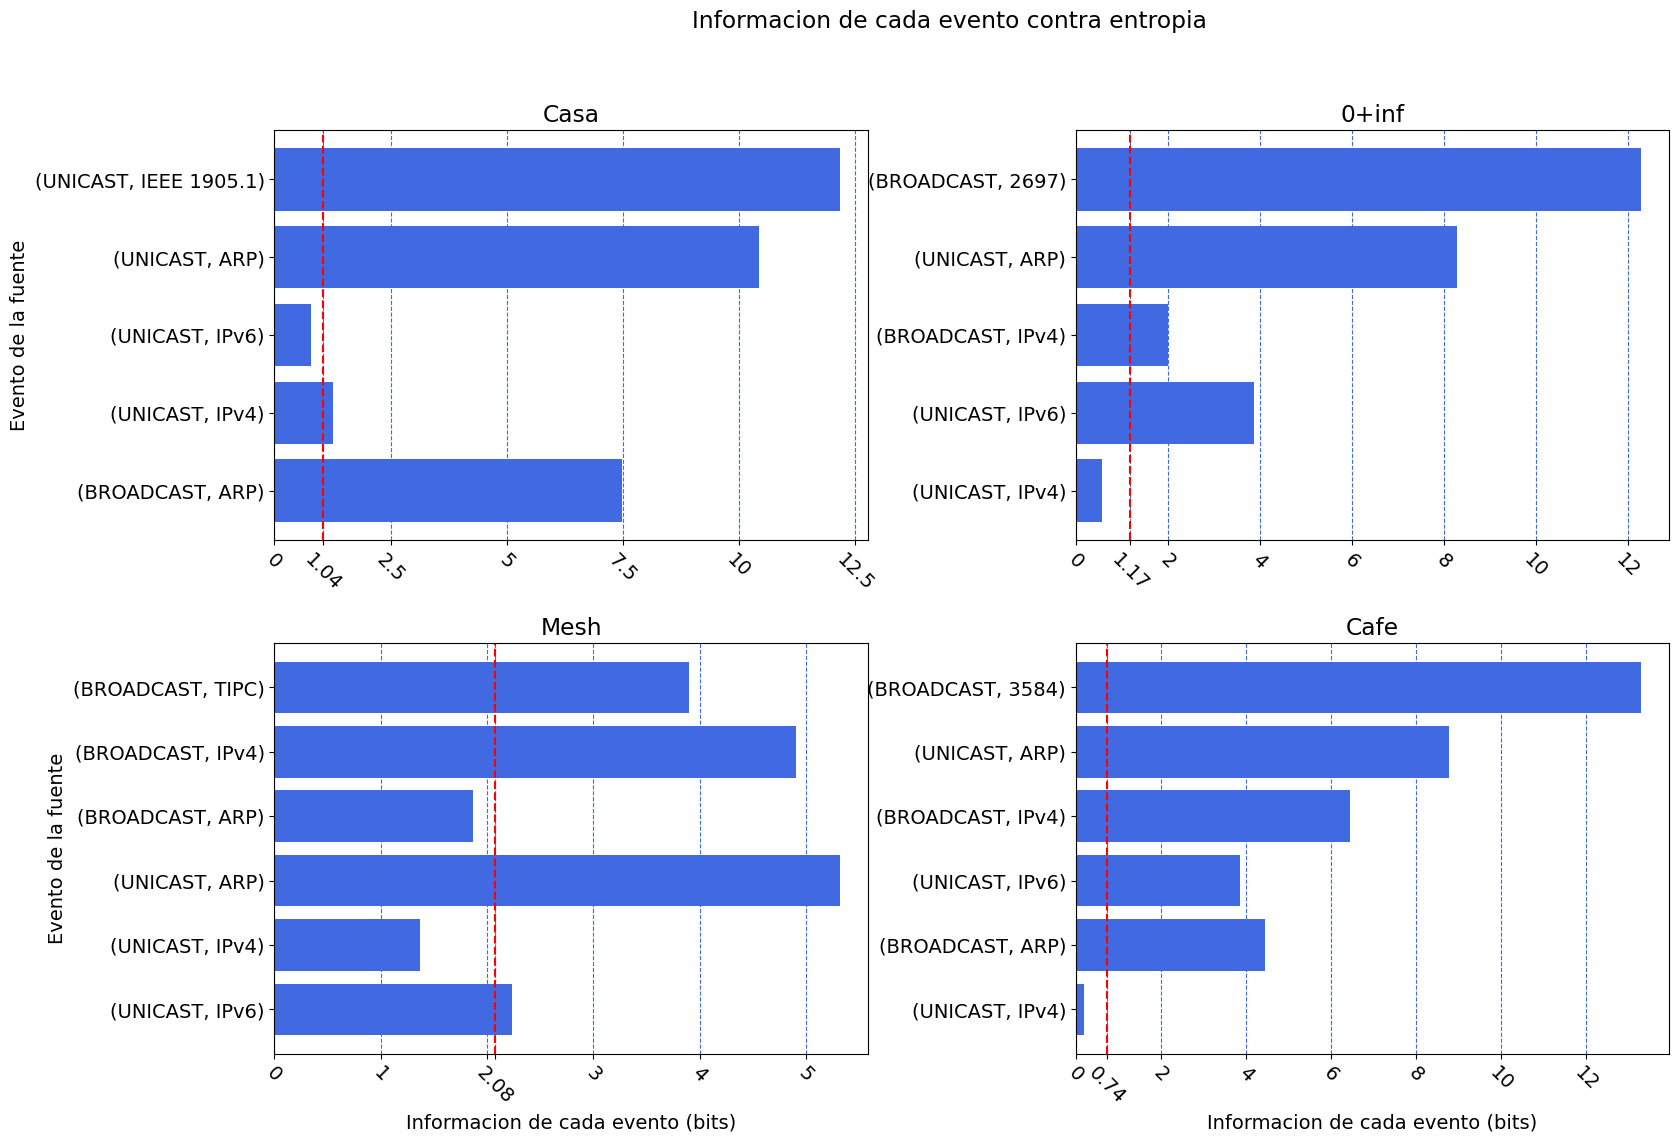

In [9]:
def graficar_barras_entropias(S1, S2, S3, S4):
    plt.rcParams.update({'font.size': 14})
    entropia1 = entropia_fuente(S1)
    entropia2 = entropia_fuente(S2)
    entropia3 = entropia_fuente(S3)
    entropia4 = entropia_fuente(S4)
    event1 = informacion_de_eventos(S1)
    event2 = informacion_de_eventos(S2)
    event3 = informacion_de_eventos(S3)
    event4 = informacion_de_eventos(S4)
    fig, ax = plt.subplots(2,2)
    plt.gcf().set_size_inches(18, 12)
    plt.subplots_adjust(hspace=0.25)
    plt.subplots_adjust(wspace=0.35)

    labels1 = list(event1.keys())
    for i in range(len(labels1)):
        if labels1[i][1] in proto_dict:
            labels1[i] = "(" + str(labels1[i][0]) + ", " + str(proto_dict[labels1[i][1]]) + ")"
        else:
            labels1[i] = "(" + str(labels1[i][0]) + ", " + str(labels1[i][1]) + ")"
    labels2 = list(event2.keys())
    for i in range(len(labels2)):
        if labels2[i][1] in proto_dict:
            labels2[i] = "(" + str(labels2[i][0]) + ", " + str(proto_dict[labels2[i][1]]) + ")"
        else:
            labels2[i] = "(" + str(labels2[i][0]) + ", " + str(labels2[i][1]) + ")"
    labels3 = list(event3.keys())
    for i in range(len(labels3)):
        if labels3[i][1] in proto_dict:
            labels3[i] = "(" + str(labels3[i][0]) + ", " + str(proto_dict[labels3[i][1]]) + ")"
        else:
            labels3[i] = "(" + str(labels3[i][0]) + ", " + str(labels3[i][1]) + ")"
    labels4 = list(event4.keys())
    for i in range(len(labels4)):
        if labels4[i][1] in proto_dict:
            labels4[i] = "(" + str(labels4[i][0]) + ", " + str(proto_dict[labels4[i][1]]) + ")"
        else:
            labels4[i] = "(" + str(labels4[i][0]) + ", " + str(labels4[i][1]) + ")"

    ax[0][0].set_title("Casa")
    ax[0][0].set_ylabel("Evento de la fuente")
    ax[0][0].set_xticks([0, entropia1, 2.5, 5, 7.5, 10, 12.5])
    ax[0][0].set_xticklabels([0, "%.2f"%entropia1, 2.5, 5, 7.5, 10, 12.5], rotation=315)
    ax[0][0].grid(axis="x", color="royalblue", linestyle="--")
    ax[0][0].axvline(x=entropia1, color="red", linestyle="--")
    ax[0][0].barh(labels1, event1.values(), color="royalblue")

    ax[0][1].set_title("0+inf")
    ax[0][1].set_xticks([0, entropia2, 2, 4, 6, 8, 10, 12])
    ax[0][1].set_xticklabels([0, "%.2f"%entropia2, 2, 4, 6, 8, 10, 12], rotation=315)
    ax[0][1].grid(axis="x", color="royalblue", linestyle="--")
    ax[0][1].axvline(x=entropia2, color="red", linestyle="--")
    ax[0][1].barh(labels2, event2.values(), color="royalblue")

    ax[1][0].set_xlabel("Informacion de cada evento (bits)")
    ax[1][0].set_title("Mesh")
    ax[1][0].set_ylabel("Evento de la fuente")
    ax[1][0].set_xticks([0, 1, entropia3, 2, 3, 4, 5])
    ax[1][0].set_xticklabels([0, 1, "%.2f"%entropia3, "", 3, 4, 5], rotation=315)
    ax[1][0].grid(axis="x", color="royalblue", linestyle="--")
    ax[1][0].axvline(x=entropia3, color="red", linestyle="--")
    ax[1][0].barh(labels3, event3.values(), color="royalblue")

    ax[1][1].set_xlabel("Informacion de cada evento (bits)")
    ax[1][1].set_title("Cafe")
    ax[1][1].set_xticks([0, entropia4, 2, 4, 6, 8, 10, 12, 14])
    ax[1][1].set_xticklabels([0, "%.2f"%entropia4, 2, 4, 6, 8, 10, 12, 14], rotation=315)
    ax[1][1].grid(axis="x", color="royalblue", linestyle="--")
    ax[1][1].axvline(x=entropia4, color="red", linestyle="--")
    ax[1][1].barh(labels4, event4.values(), color="royalblue")

    plt.suptitle("Informacion de cada evento contra entropia")
    plt.savefig("SVG/ChauTablaEsquizofrenica.svg", format="svg")
    plt.show()

graficar_barras_entropias(S1, S2, S3, S4)

<h1>OPCIONAL ARP</h1>

<h2>Tomando como simbolo las IP fuente</h2>

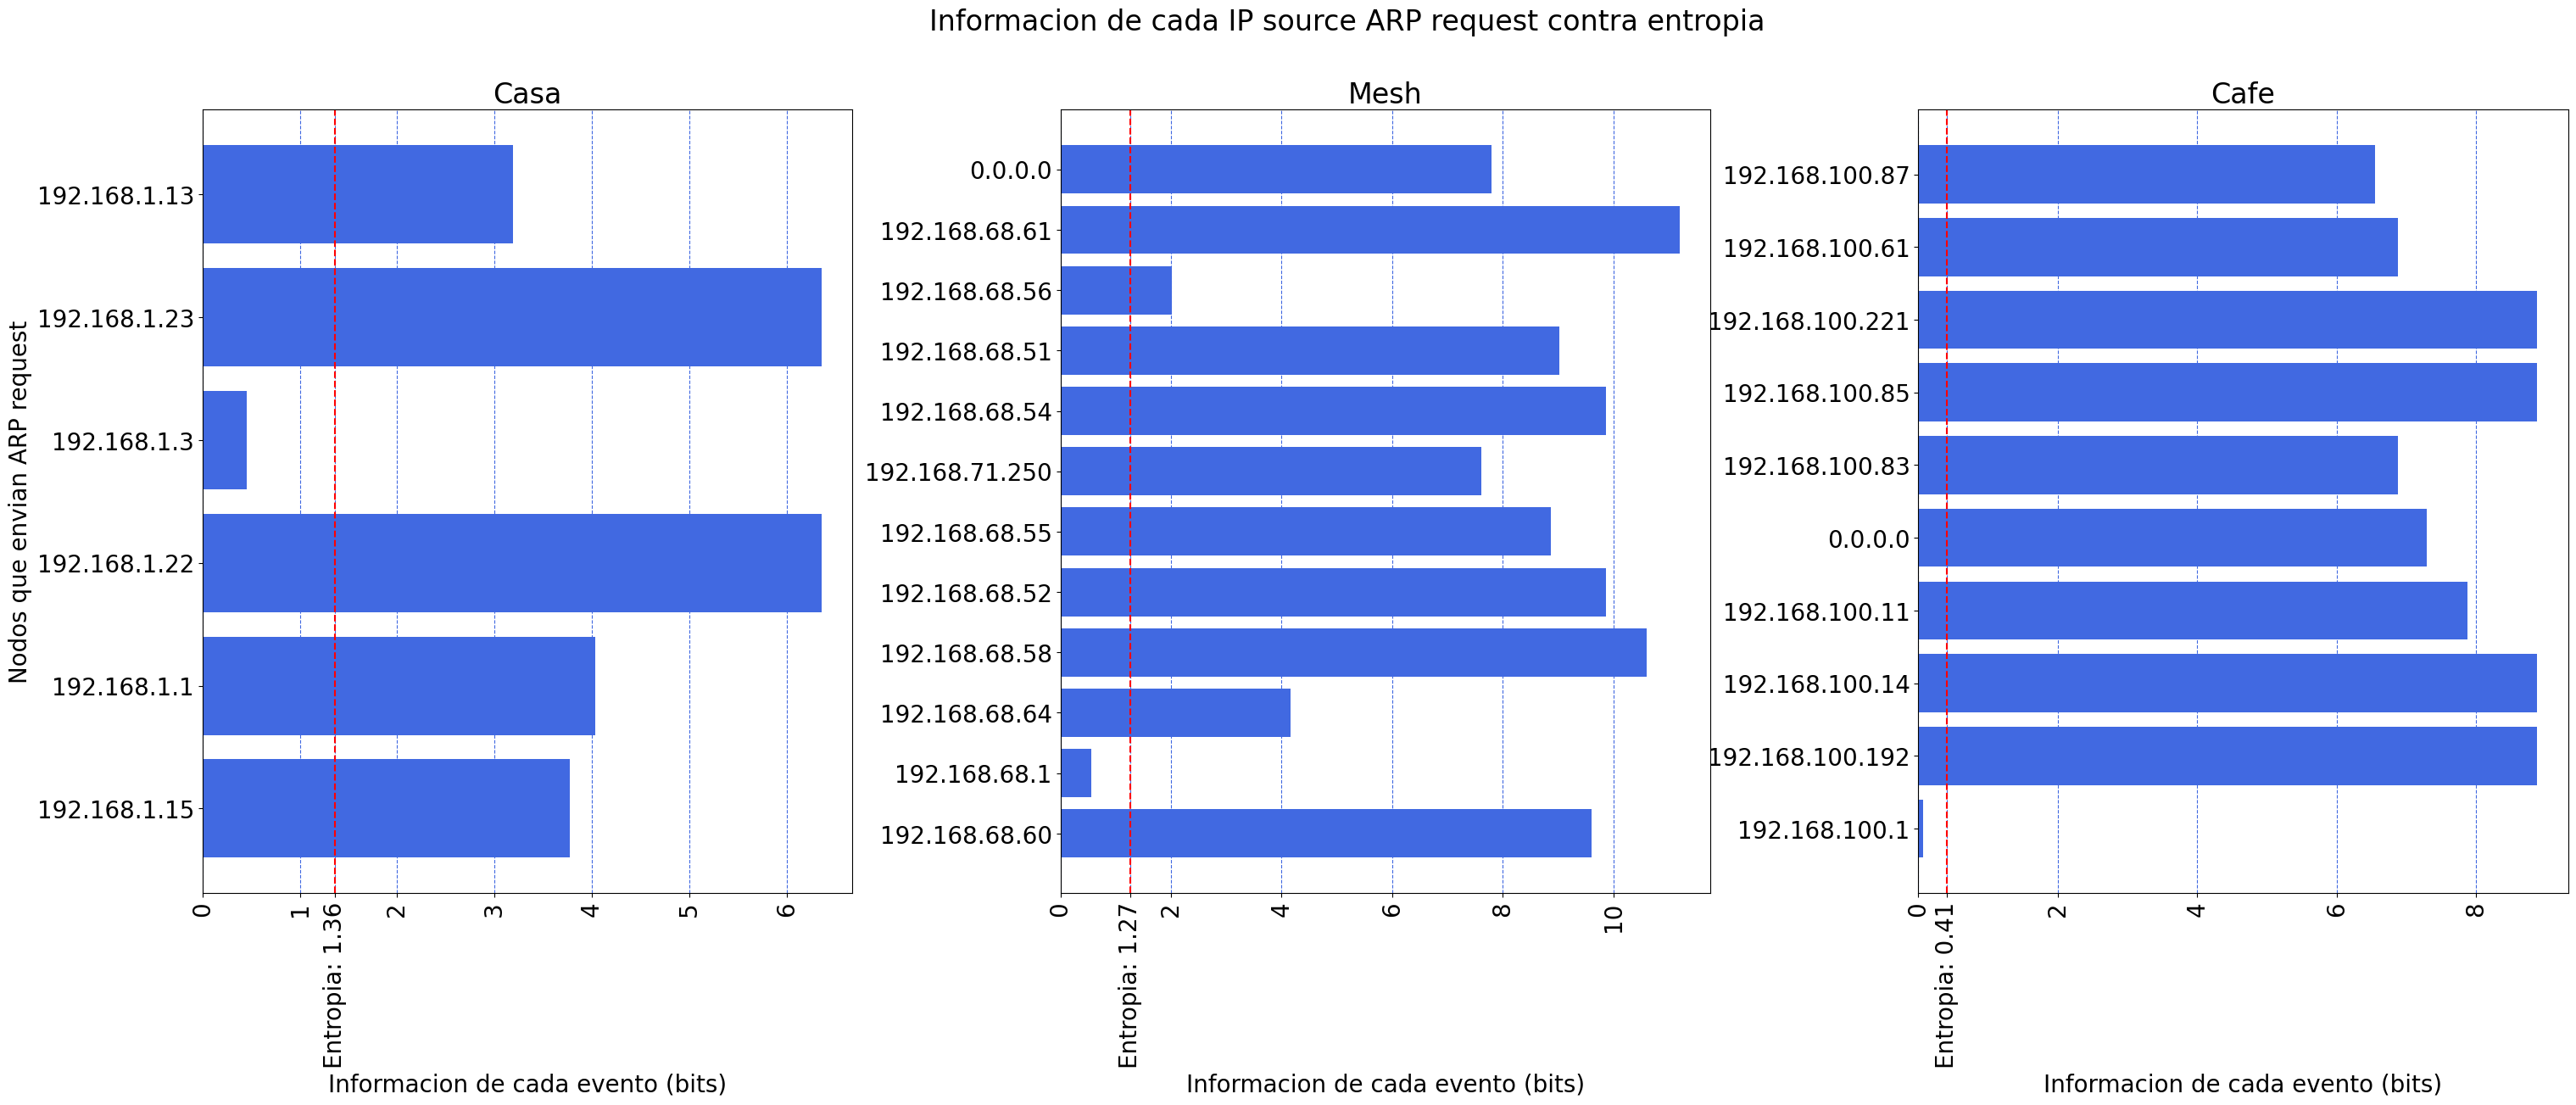

In [10]:
ARP1 = filtrar_ARP_opcional_req_src(dump_de_frames1)
ARP3 = filtrar_ARP_opcional_req_src(dump_de_frames3)
ARP4 = filtrar_ARP_opcional_req_src(dump_de_frames4)

def graficar_barras_ARP(S1, S3, S4):
    plt.rcParams.update({'font.size': 20})
    entropia1 = entropia_fuente(S1)
    entropia3 = entropia_fuente(S3)
    entropia4 = entropia_fuente(S4)
    event1 = informacion_de_eventos(S1)
    event3 = informacion_de_eventos(S3)
    event4 = informacion_de_eventos(S4)
    fig, ax = plt.subplots(1,3)
    plt.gcf().set_size_inches(36, 12)

    ax[0].set_xlabel("Informacion de cada evento (bits)")
    ax[0].set_title("Casa")
    ax[0].set_ylabel("Nodos que envian ARP request")
    ax[0].set_xticks([0, 1, entropia1, 2, 3, 4, 5, 6, 7])
    ax[0].set_xticklabels([0, 1, "Entropia: %.2f"%entropia1, 2, 3, 4, 5, 6, 7], rotation=90)
    ax[0].grid(axis="x", color="royalblue", linestyle="--")
    ax[0].axvline(x=entropia1, color="red", linestyle="--")
    ax[0].barh(list(event1.keys()), event1.values(), color="royalblue")

    ax[1].set_xlabel("Informacion de cada evento (bits)")
    ax[1].set_title("Mesh")
    ax[1].set_xticks([0, entropia3, 2, 4, 6, 8, 10, 12])
    ax[1].set_xticklabels([0, "Entropia: %.2f"%entropia3, 2, 4, 6, 8, 10, 12], rotation=90)
    ax[1].grid(axis="x", color="royalblue", linestyle="--")
    ax[1].axvline(x=entropia3, color="red", linestyle="--")
    ax[1].barh(list(event3.keys()), event3.values(), color="royalblue")

    ax[2].set_xlabel("Informacion de cada evento (bits)")
    ax[2].set_title("Cafe")
    ax[2].set_xticks([0, entropia4, 2, 4, 6, 8, 10])
    ax[2].set_xticklabels([0, "Entropia: %.2f"%entropia4, 2, 4, 6, 8, 10], rotation=90)
    ax[2].grid(axis="x", color="royalblue", linestyle="--")
    ax[2].axvline(x=entropia4, color="red", linestyle="--")
    ax[2].barh(list(event4.keys()), event4.values(), color="royalblue")

    plt.subplots_adjust(wspace=0.32)
    plt.suptitle("Informacion de cada IP source ARP request contra entropia")
    plt.savefig("SVG/ARP.svg", format="svg")
    plt.show()

graficar_barras_ARP(ARP1, ARP3, ARP4)

<h2>Tomando como simbolo las IP destino</h2>

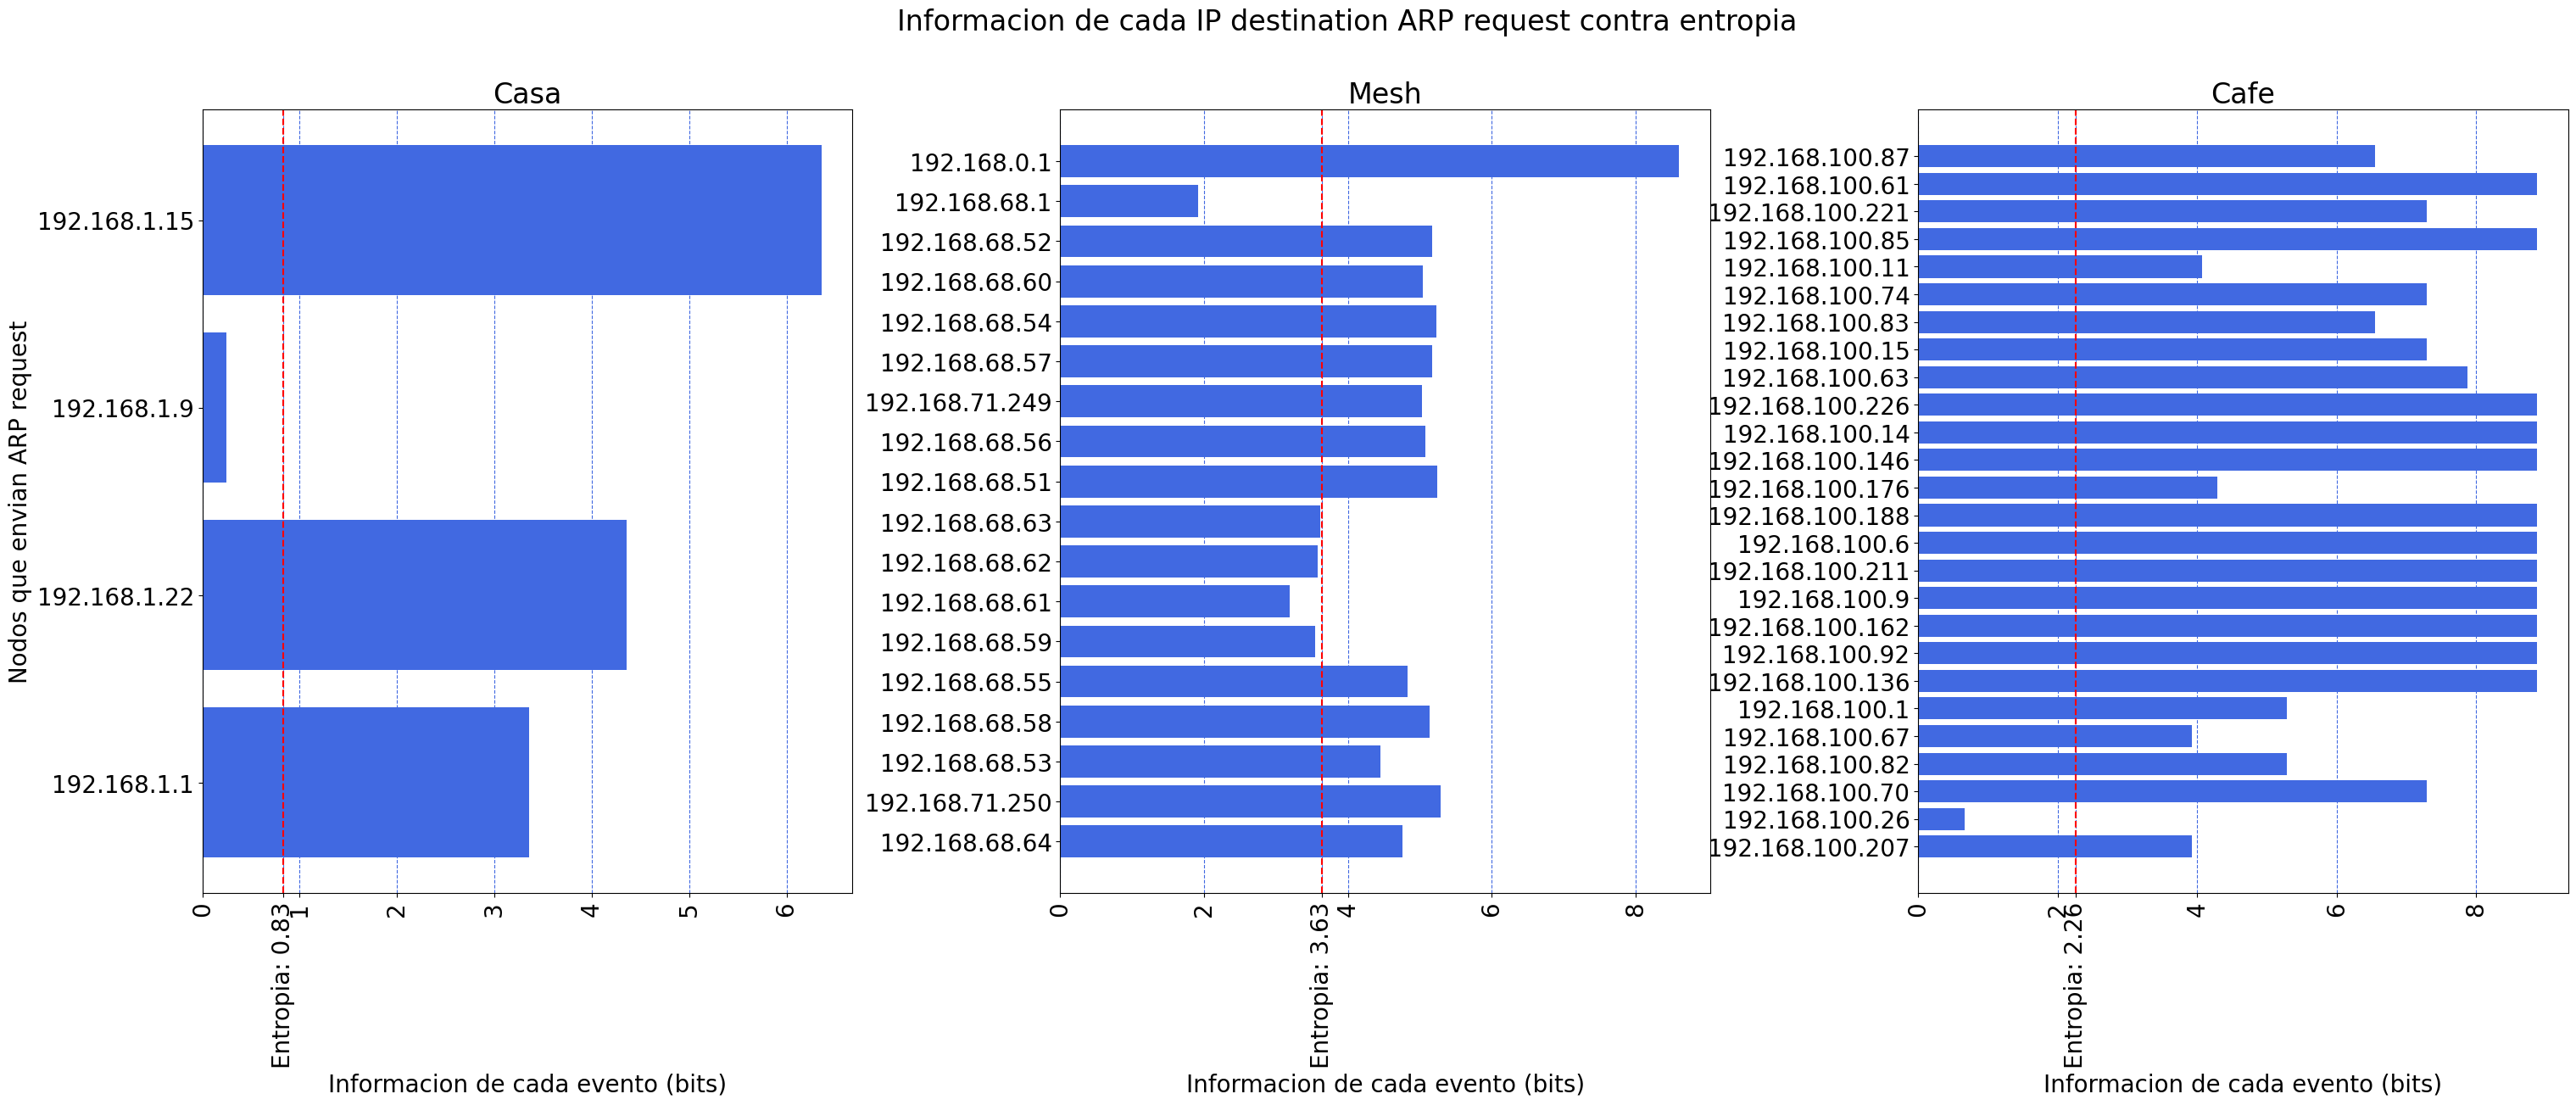

In [11]:
ARP1 = filtrar_ARP_opcional_req_dst(dump_de_frames1)
ARP3 = filtrar_ARP_opcional_req_dst(dump_de_frames3)
ARP4 = filtrar_ARP_opcional_req_dst(dump_de_frames4)

def graficar_barras_ARP(S1, S3, S4):
    plt.rcParams.update({'font.size': 20})
    entropia1 = entropia_fuente(S1)
    entropia3 = entropia_fuente(S3)
    entropia4 = entropia_fuente(S4)
    event1 = informacion_de_eventos(S1)
    event3 = informacion_de_eventos(S3)
    event4 = informacion_de_eventos(S4)
    fig, ax = plt.subplots(1,3)
    plt.gcf().set_size_inches(36, 12)

    ax[0].set_xlabel("Informacion de cada evento (bits)")
    ax[0].set_title("Casa")
    ax[0].set_ylabel("Nodos que envian ARP request")
    ax[0].set_xticks([0, 1, entropia1, 2, 3, 4, 5, 6, 7])
    ax[0].set_xticklabels([0, 1, "Entropia: %.2f"%entropia1, 2, 3, 4, 5, 6, 7], rotation=90)
    ax[0].grid(axis="x", color="royalblue", linestyle="--")
    ax[0].axvline(x=entropia1, color="red", linestyle="--")
    ax[0].barh(list(event1.keys()), event1.values(), color="royalblue")

    ax[1].set_xlabel("Informacion de cada evento (bits)")
    ax[1].set_title("Mesh")
    ax[1].set_xticks([0, entropia3, 2, 4, 6, 8, 10, 12])
    ax[1].set_xticklabels([0, "Entropia: %.2f"%entropia3, 2, 4, 6, 8, 10, 12], rotation=90)
    ax[1].grid(axis="x", color="royalblue", linestyle="--")
    ax[1].axvline(x=entropia3, color="red", linestyle="--")
    ax[1].barh(list(event3.keys()), event3.values(), color="royalblue")

    ax[2].set_xlabel("Informacion de cada evento (bits)")
    ax[2].set_title("Cafe")
    ax[2].set_xticks([0, entropia4, 2, 4, 6, 8, 10])
    ax[2].set_xticklabels([0, "Entropia: %.2f"%entropia4, 2, 4, 6, 8, 10], rotation=90)
    ax[2].grid(axis="x", color="royalblue", linestyle="--")
    ax[2].axvline(x=entropia4, color="red", linestyle="--")
    ax[2].barh(list(event4.keys()), event4.values(), color="royalblue")

    plt.subplots_adjust(wspace=0.32)
    plt.suptitle("Informacion de cada IP destination ARP request contra entropia")
    plt.savefig("SVG/ARP2.svg", format="svg")
    plt.show()

graficar_barras_ARP(ARP1, ARP3, ARP4)